# Chemical Compound Boiling Points Prediction

In this project, I developed a ML model that can accurately predict the boiling points of chemical compounds from their chemical properties. The workflow includes *Data Collection*,*Data pre-processing and clearning*, *Model selection and training*, and *Model evaluation*. Five classic machine learning architectures, including **Linear Regression**, **Random Forest**, **XGBoost**, **Neural Network**, and **Support Vector Regression**, were trained and evaluated.
## Summary of Results
A XGBoost ML model was developed for the prediction of chemical boiling points. The model developed has a RMSE of 39. To further improve the model performance, more data (particularly more data with large polar area and/or rotbonds) should be collected to re-train the model.



# Data Collection
 

1. Chemical structure data is widely accessible online and I collected a large dataset of chemical compounds and their chemical properties from PubChem, a trusted and reputable chemical database. The file "compound_property_from_PubChem.csv" is downloaded from PubChem (https://pubchem.ncbi.nlm.nih.gov/). It contains 324,628 records. I mannually deleted some columns  of the raw data file downloaded, mainly string type columns, to reduce the file size.
2. High-quality physical property data is less commonly available through public APIs. I sourced a smaller but well-documented dataset from a published academic journal article. The file "compound_boiling_points_from_literature.xlsx" is accessed from a literature (https://pubs.acs.org/doi/10.1021/acs.jchemed.3c01040). It contains 1748 records.
    

In [2]:
# Import libraries and packages
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score


# Read data 

In [3]:
# Load the data on compound boiling points
df1 = pd.read_excel("compound_boiling_points_from_literature.xlsx")
print(df1.head())
print()
print(df1.shape)
print()
print(df1.info())
print()
# check is there are null values
print(df1.isna().sum()) 

          cmpdname  boiling_point_kelvin
0  Ethylene Glycol                470.65
1   2,3-Butanediol                455.15
2        1-Butanol                390.75
3          Methane                111.65
4           Octane                398.77

(1748, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1748 entries, 0 to 1747
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cmpdname              1748 non-null   object 
 1   boiling_point_kelvin  1748 non-null   float64
dtypes: float64(1), object(1)
memory usage: 27.4+ KB
None

cmpdname                0
boiling_point_kelvin    0
dtype: int64


In [4]:
# load the compound physichemical property file
df2 = pd.read_csv("compound_property_from_PubChem.csv")
# df2.head()
print(df2.columns)
print(df2.shape)
# Select properties that are potentionly useful for model development, needs some background knowledge
df2=df2[['cmpdname','mw', 'mf', 'polararea','hbonddonor', 'hbondacc', 'rotbonds','heavycnt','isosmiles','charge']]

Index(['cid', 'cmpdname', 'mw', 'mf', 'polararea', 'complexity', 'xlogp',
       'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds', 'isosmiles',
       'canonicalsmiles', 'charge', 'covalentunitcnt', 'isotopeatomcnt',
       'totalatomstereocnt', 'definedatomstereocnt', 'undefinedatomstereocnt',
       'totalbondstereocnt', 'definedbondstereocnt', 'undefinedbondstereocnt',
       'pclidcnt', 'gpidcnt', 'gpfamilycnt', 'annothitcnt'],
      dtype='object')
(324628, 26)


# Data Pre-processing and Exploratory Data Analysis
1. Get information of the dataset
2. Feature engineering for modelling


In [5]:
# merge the dataset from PubChem (phychemical property data) with boiling point data
df = df1.merge(df2, on='cmpdname',how='inner')
df.head()

,cmpdname,boiling_point_kelvin,mw,mf,polararea,hbonddonor,hbondacc,rotbonds,heavycnt,isosmiles,charge
0,Ethylene Glycol,470.65,62.070,C2H6O2,40.5,2,2,1,4,C(CO)O,0
1,"2,3-Butanediol",455.15,90.120,C4H10O2,40.5,2,2,1,6,CC(C(C)O)O,0
2,1-Butanol,390.75,74.120,C4H10O,20.2,1,1,2,5,CCCCO,0
3,Methane,111.65,16.043,CH4,0.0,0,0,0,1,C,0
4,Octane,398.77,114.230,C8H18,0.0,0,0,5,8,CCCCCCCC,0


In [6]:
# check basic information about the data
print (df.shape)
print()
print((df.isna().sum()))
print()
df.info()

(1588, 11)

cmpdname                0
boiling_point_kelvin    0
mw                      0
mf                      0
polararea               0
hbonddonor              0
hbondacc                0
rotbonds                0
heavycnt                0
isosmiles               0
charge                  0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1588 entries, 0 to 1587
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cmpdname              1588 non-null   object 
 1   boiling_point_kelvin  1588 non-null   float64
 2   mw                    1588 non-null   float64
 3   mf                    1588 non-null   object 
 4   polararea             1588 non-null   float64
 5   hbonddonor            1588 non-null   int64  
 6   hbondacc              1588 non-null   int64  
 7   rotbonds              1588 non-null   int64  
 8   heavycnt              1588 non-null   int64  
 9   isosmiles      

In [7]:
df.head()

,cmpdname,boiling_point_kelvin,mw,mf,polararea,hbonddonor,hbondacc,rotbonds,heavycnt,isosmiles,charge
0,Ethylene Glycol,470.65,62.070,C2H6O2,40.5,2,2,1,4,C(CO)O,0
1,"2,3-Butanediol",455.15,90.120,C4H10O2,40.5,2,2,1,6,CC(C(C)O)O,0
2,1-Butanol,390.75,74.120,C4H10O,20.2,1,1,2,5,CCCCO,0
3,Methane,111.65,16.043,CH4,0.0,0,0,0,1,C,0
4,Octane,398.77,114.230,C8H18,0.0,0,0,5,8,CCCCCCCC,0


In [8]:
# Feature engineering for features that might be useful for predicting boiling points (background knowledge)
df['C_cnt']=df['isosmiles'].apply(lambda x: x.count('C')) # C numbers
df['O_cnt']=df['isosmiles'].apply(lambda x: x.count('O')) # O number
df['N_cnt']=df['isosmiles'].apply(lambda x: x.count('N')) # N number
df['F_cnt']=df['isosmiles'].apply(lambda x: x.count('F')) # F number
df['side_chain_cnt']=df['isosmiles'].apply(lambda x: x.count('(')) # side chain number
df['double_bond_cnt']=df['isosmiles'].apply(lambda x: x.count('=')) # double bond number
df['triple_bond_cnt']=df['isosmiles'].apply(lambda x: x.count('#')) # triple bond number

In [9]:
df.head()

,cmpdname,boiling_point_kelvin,mw,mf,polararea,hbonddonor,hbondacc,rotbonds,heavycnt,isosmiles,charge,C_cnt,O_cnt,N_cnt,F_cnt,side_chain_cnt,double_bond_cnt,triple_bond_cnt
0,Ethylene Glycol,470.65,62.070,C2H6O2,40.5,2,2,1,4,C(CO)O,0,2,2,0,0,1,0,0
1,"2,3-Butanediol",455.15,90.120,C4H10O2,40.5,2,2,1,6,CC(C(C)O)O,0,4,2,0,0,2,0,0
2,1-Butanol,390.75,74.120,C4H10O,20.2,1,1,2,5,CCCCO,0,4,1,0,0,0,0,0
3,Methane,111.65,16.043,CH4,0.0,0,0,0,1,C,0,1,0,0,0,0,0,0
4,Octane,398.77,114.230,C8H18,0.0,0,0,5,8,CCCCCCCC,0,8,0,0,0,0,0,0


In [10]:
# Get basic staticalinformation of the dataset
df.describe()

,boiling_point_kelvin,mw,polararea,hbonddonor,hbondacc,rotbonds,heavycnt,charge,C_cnt,O_cnt,N_cnt,F_cnt,side_chain_cnt,double_bond_cnt,triple_bond_cnt
count,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000,1588.0,1588.000000,1588.000000,1588.000000,1588.0,1588.000000,1588.000000,1588.000000
mean,476.406926,160.281980,10.991120,0.511965,0.617128,6.375315,11.290932,0.0,10.672544,0.488665,0.128463,0.0,1.583123,0.397355,0.098237
std,126.277949,84.086372,17.074557,0.794107,0.960864,6.185757,5.979781,0.0,6.105238,0.917792,0.454477,0.0,1.389044,0.797076,0.341127
min,111.650000,16.043000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,403.900000,112.210000,0.000000,0.000000,0.000000,3.000000,8.000000,0.0,7.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,451.150000,142.280000,0.000000,0.000000,0.000000,5.000000,10.000000,0.0,9.500000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000
75%,511.150000,174.280000,20.200000,1.000000,1.000000,8.000000,12.000000,0.0,12.000000,1.000000,0.000000,0.0,2.000000,1.000000,0.000000
max,1343.160000,703.300000,180.000000,8.000000,10.000000,46.000000,50.000000,0.0,50.000000,10.000000,6.000000,0.0,10.000000,13.000000,3.000000


In [45]:
df.columns

Index(['cmpdname', 'boiling_point_kelvin', 'mw', 'mf', 'polararea',
       'hbonddonor', 'hbondacc', 'rotbonds', 'heavycnt', 'isosmiles', 'C_cnt',
       'O_cnt', 'N_cnt', 'side_chain_cnt', 'double_bond_cnt',
       'triple_bond_cnt'],
      dtype='object')

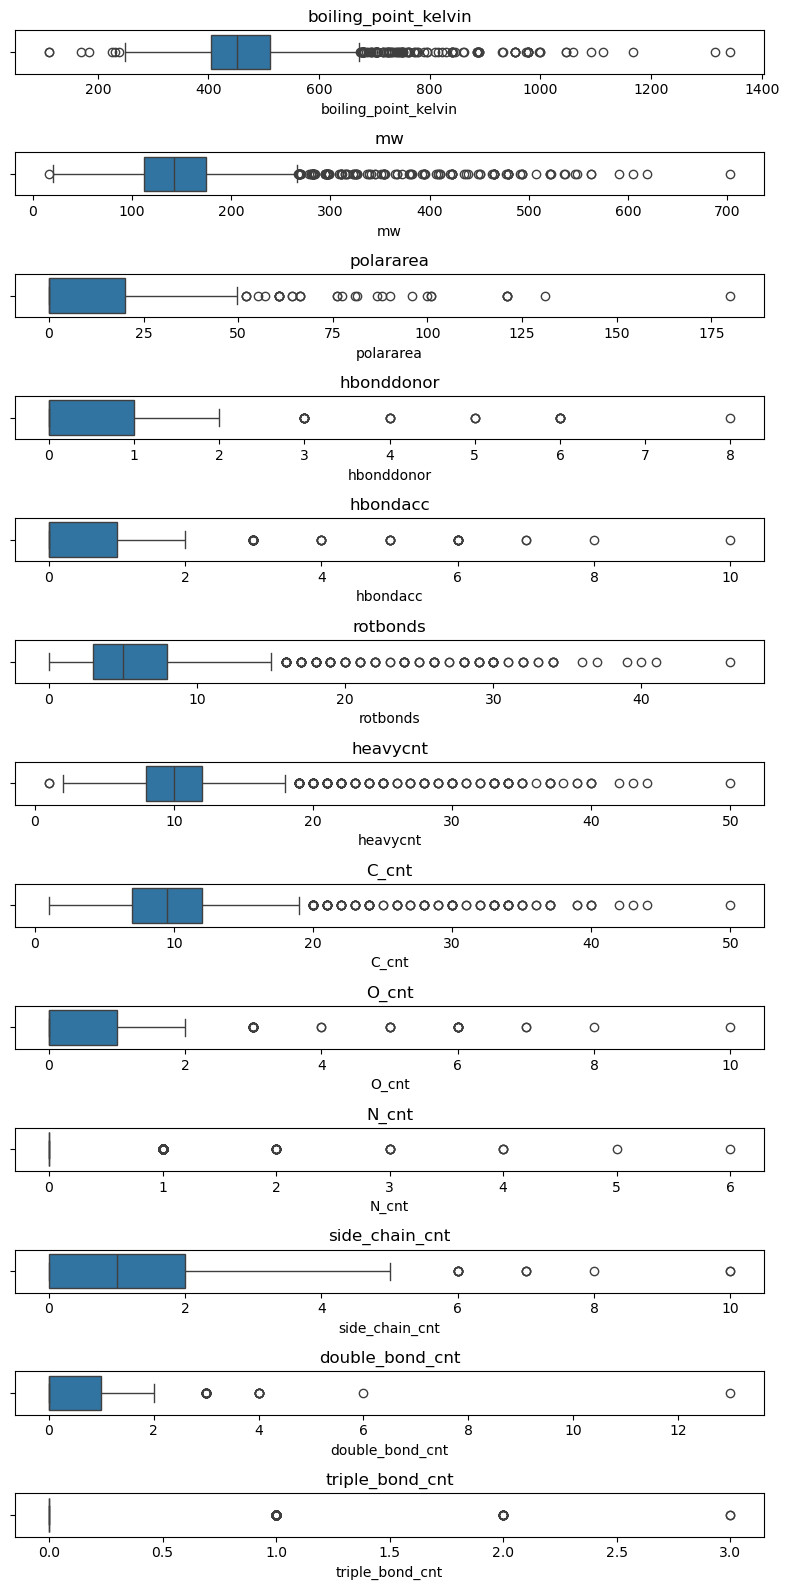

In [48]:
# Check outliers 

# Select only numeric columns for plotting
numeric_df = df.select_dtypes(include='number')
fig, axes = plt.subplots(nrows=len(numeric_df.columns), figsize=(8, len(df.columns)*1))

for i, col in enumerate(numeric_df.columns):
    sns.boxplot(x=numeric_df[col], ax=axes[i], orient='h')
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

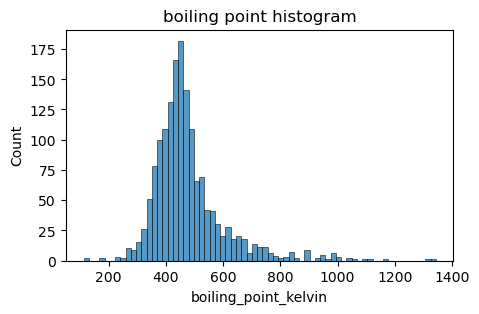

In [52]:
plt.figure(figsize=(5,3))
sns.histplot(df['boiling_point_kelvin'])
plt.title('boiling point histogram')
plt.show()

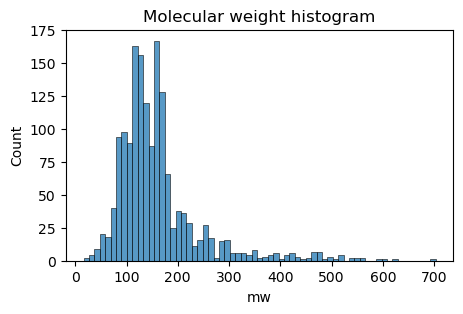

In [51]:
plt.figure(figsize=(5,3))
sns.histplot(df['mw'])
plt.title('Molecular weight histogram')
plt.show()

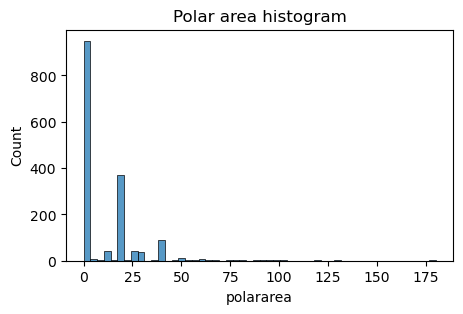

In [53]:
plt.figure(figsize=(5,3))
sns.histplot(df['polararea'])
plt.title('Polar area histogram')
plt.show()

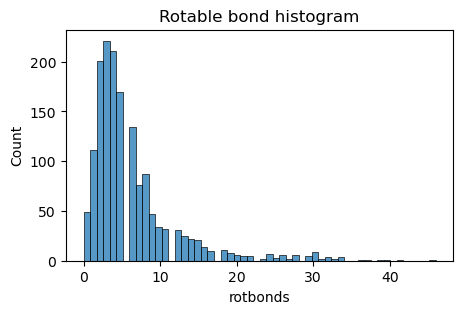

In [54]:
plt.figure(figsize=(5,3))
sns.histplot(df['rotbonds'])
plt.title('Rotable bond number histogram')
plt.show()

* There are outliers in the data, particularly there is a small amount of data with high molecular weight or polar area or rotable bond number. Those data are real though rare.
* We will not remove those outliers as we want our model to predict for those cases too.

In [11]:
# Get correlation matrix to help determine most correlated variables
df.corr(numeric_only=True)

,boiling_point_kelvin,mw,polararea,hbonddonor,hbondacc,rotbonds,heavycnt,charge,C_cnt,O_cnt,N_cnt,F_cnt,side_chain_cnt,double_bond_cnt,triple_bond_cnt
boiling_point_kelvin,1.000000,0.896967,0.241092,0.229715,0.233364,0.858528,0.890193,NaN,0.835444,0.264343,-0.040444,NaN,0.052948,-0.107336,-0.093213
mw,0.896967,1.000000,-0.058511,-0.079914,-0.024446,0.972335,0.999402,NaN,0.982917,-0.015383,-0.020619,NaN,0.011180,-0.093989,-0.108088
polararea,0.241092,-0.058511,1.000000,0.968981,0.953218,-0.061547,-0.083576,NaN,-0.231747,0.877727,0.242792,NaN,0.072172,-0.173303,-0.082285
hbonddonor,0.229715,-0.079914,0.968981,1.000000,0.884672,-0.085193,-0.103175,NaN,-0.240155,0.798616,0.257631,NaN,0.088499,-0.166299,-0.076451
hbondacc,0.233364,-0.024446,0.953218,0.884672,1.000000,-0.022667,-0.050350,NaN,-0.206566,0.883944,0.329144,NaN,0.045577,-0.182983,-0.090876
rotbonds,0.858528,0.972335,-0.061547,-0.085193,-0.022667,1.000000,0.971250,NaN,0.955022,-0.032103,0.016908,NaN,-0.191885,-0.113336,-0.119909
heavycnt,0.890193,0.999402,-0.083576,-0.103175,-0.050350,0.971250,1.000000,NaN,0.987575,-0.039813,-0.026050,NaN,0.004445,-0.073713,-0.092790
charge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C_cnt,0.835444,0.982917,-0.231747,-0.240155,-0.206566,0.955022,0.987575,NaN,1.000000,-0.178003,-0.077258,NaN,-0.002881,-0.043297,-0.076521
O_cnt,0.264343,-0.015383,0.877727,0.798616,0.883944,-0.032103,-0.039813,NaN,-0.178003,1.000000,-0.150594,NaN,0.092673,-0.134670,-0.062858


In [12]:
df=df.drop(['charge','F_cnt'], axis=1) # Drop 'charge' and 'F_cnt' column as there is no correlation at all 
df

,cmpdname,boiling_point_kelvin,mw,mf,polararea,hbonddonor,hbondacc,rotbonds,heavycnt,isosmiles,C_cnt,O_cnt,N_cnt,side_chain_cnt,double_bond_cnt,triple_bond_cnt
0,Ethylene Glycol,470.65,62.070,C2H6O2,40.5,2,2,1,4,C(CO)O,2,2,0,1,0,0
1,"2,3-Butanediol",455.15,90.120,C4H10O2,40.5,2,2,1,6,CC(C(C)O)O,4,2,0,2,0,0
2,1-Butanol,390.75,74.120,C4H10O,20.2,1,1,2,5,CCCCO,4,1,0,0,0,0
3,Methane,111.65,16.043,CH4,0.0,0,0,0,1,C,1,0,0,0,0,0
4,Octane,398.77,114.230,C8H18,0.0,0,0,5,8,CCCCCCCC,8,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1583,"3,5-Dimethyl-2,4-heptadiene",413.15,124.220,C9H16,0.0,0,0,2,9,CC/C(=C/C(=C/C)/C)/C,9,0,0,2,2,0
1584,"2,2,4,4-Tetramethyl-3-hexanol",460.65,158.280,C10H22O,20.2,1,1,3,11,CCC(C)(C)[C@@H](C(C)(C)C)O,10,1,0,5,0,0
1585,"3,3-Dimethyl-2-ethyl-1-butanol",471.15,130.229,C8H18O,20.2,1,1,3,9,CC[C@@H](CO)C(C)(C)C,8,1,0,3,0,0
1586,"3,3,4-Trimethyl-2-pentanol",437.90,130.229,C8H18O,20.2,1,1,2,9,C[C@@H](C(C)(C)C(C)C)O,8,1,0,4,0,0


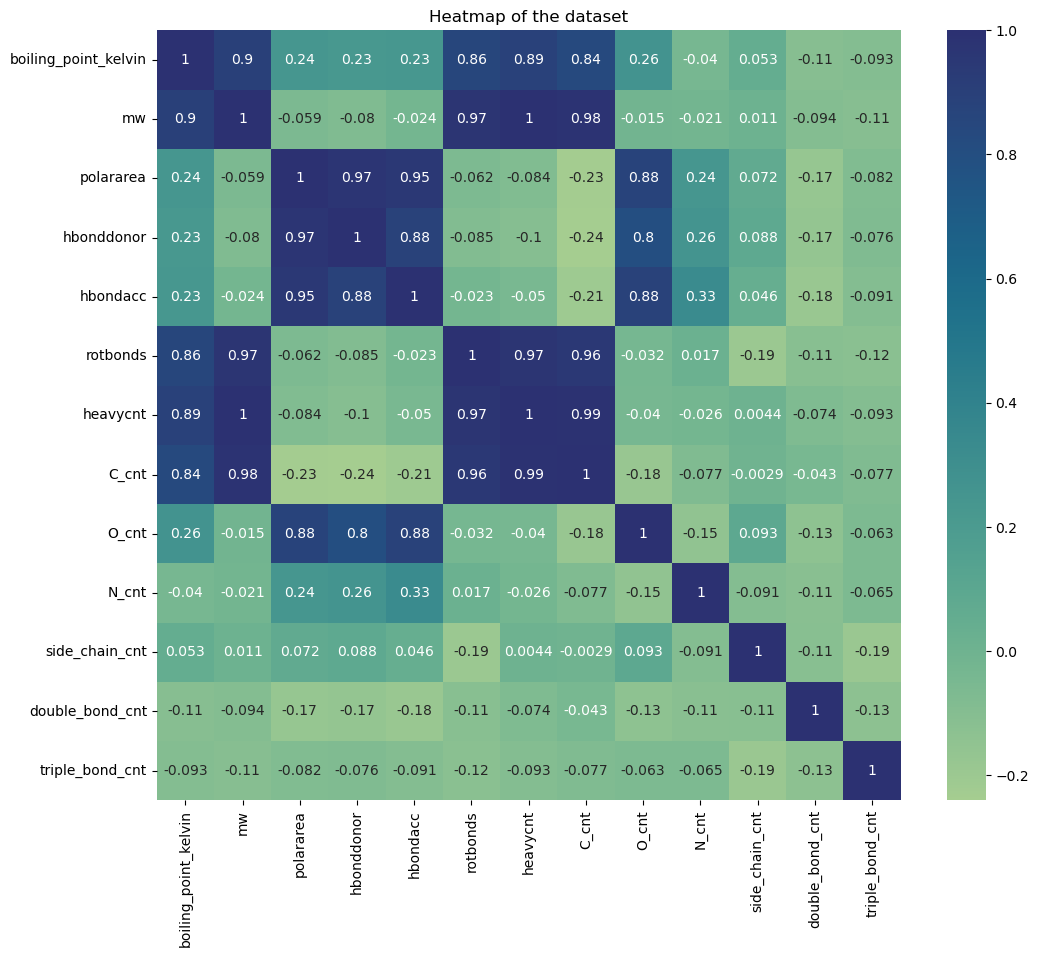

In [13]:
# Create a heatmap to visualize how correlated variables are
plt.figure(figsize=(12, 10))
sns.heatmap(
    df.corr(numeric_only=True), 
    annot=True, 
    cmap="crest")
plt.title("Heatmap of the dataset")
plt.show()


  *   Variables that are correlated with boiling points are: "mw"	"polararea", "heavycnt", "rotbonds", "C_cnt", 'O_cnt', "hbonddonor",	"hbondacc". However, it is noted that some of those variables are (closely) correlated, like ["mw", "heavycnt", "C_cunt", and "rotbonds"],  ["hbonddonor" and "hbondacc"]. It is not necessary to choose all of them if we need to mannually select features for models selected; tree-based models will selct features intrinsically.
  *   These make sense as the major factors affecting boiling points theretically include: molecular weight (Van Der Waals force), ploarity and O_cnt (hydrogen bonding, dipole-dipole attraction ), ionic bonding (charge 0 here, so not a factor for our data)

# Model construction
 * Approach
 1. Split the data into training/validation/test.
 2. Cross-validate/tune hyperparameters on the training dataset with GridSearchCV for each chosen ML architecyutre.
 3. Compare the tuned model of each different architecture on the validation dataset and select the ‘champion’ ML architecture.
 4. Retrain the champion model using training dataset + validation dataset, and further use that model to predict (check model performance on test dataset and predict unknown boiling points)

 *  Five ML architectures are tested ,including
 1. Linear regression
 2. Random forest
 3. XGBoost
 4. Neural network
 5. Support Vector Regressionk


## Prepare the dataset for model training

In [55]:
#Show column names
df.columns

Index(['cmpdname', 'boiling_point_kelvin', 'mw', 'mf', 'polararea',
       'hbonddonor', 'hbondacc', 'rotbonds', 'heavycnt', 'isosmiles', 'C_cnt',
       'O_cnt', 'N_cnt', 'side_chain_cnt', 'double_bond_cnt',
       'triple_bond_cnt'],
      dtype='object')

In [179]:
# Define the y (target) variable
y = df['boiling_point_kelvin']

# Define the X (predictor) variables
X = df.copy()
X = X[['mw', 'polararea', 'hbonddonor', 'hbondacc', 'rotbonds', 'heavycnt', 'C_cnt',
       'O_cnt', 'N_cnt', 'side_chain_cnt', 'double_bond_cnt','triple_bond_cnt']] # select the numerical columns
# X_columns=X.columns

# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training data into training and validation sets
# A final ratio of 60/20/20 for train/validate/test setsy
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=42)
# Get shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((952, 12), (318, 12), (318, 12), (952,), (318,), (318,))

In [180]:
# X_train.describe()

## Linear regression model

In [181]:
# Normalise the data
# Normalsed data will be used for linear regresson model and later for neural network model

scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit the scaler on X_train and transform 
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)  
X_test_scaled = scaler_X.transform(X_test)

# Fit the scaler on y_train and transform
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_train_scaled = y_train_scaled.ravel()  # Flatten the array

# Transform y_val and y_test using the same scaler_y
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_val_scaled = y_val_scaled.ravel()

y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))
y_test_scaled = y_test_scaled.ravel()

In [182]:
# Initialize Ridge model
lr = Ridge()

# Define hyperparameters for tuning
param_grid = {'alpha': [0.1, 1, 10, 100, 1000]}

start_time = time.time()
# Initialize GridSearchCV
lr_cv = GridSearchCV(lr, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
# Fit the model with GridSearchCV
lr_cv.fit(X_train_scaled, y_train_scaled)
end_time = time.time()
print(f"Time taken for Grid Search training: {end_time - start_time:.2f} seconds")
print()
# Get best model and print the best alpha
best_ridge = lr_cv.best_estimator_

print("Best alpha:", lr_cv.best_params_)
print("Coefficients:", best_ridge.coef_)
print("Intercept:", best_ridge.intercept_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Time taken for Grid Search training: 0.07 seconds

Best alpha: {'alpha': 0.1}
Coefficients: [ 0.4417069  -0.02561774  0.39071091  0.01186223 -0.46095558  0.47287322
  0.47497381  0.04683786 -0.0672971  -0.08105726  0.00096665 -0.00921201]
Intercept: 3.927714829181231e-16


In [183]:
mse_scaled=-lr_cv.best_score_
print(f'MSE on the scaled data: {mse_scaled: .4f}')

# Transform the MSE on scaled data to MSE on unscaled data
y_train_variance = np.var(y_train) # the variance of the original target variable y

mse_unscaled = mse_scaled * y_train_variance
lr_rmse_unscaled = np.sqrt(mse_unscaled )
print (f'MSE on the unscaled data: {mse_unscaled: .4f}')
print (f'RMSE on the unscaled data: {lr_rmse_unscaled:.4f}')

MSE on the scaled data:  0.0793
MSE on the unscaled data:  1376.6707
RMSE on the unscaled data: 37.1035


## Random forest model

In [184]:
# Here I use the unscaled data for tree-base models
# Instantiate the random forest classifier
rf = RandomForestRegressor(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 10, None],
             'max_features': ['sqrt', 0.6],
             'max_samples': [0.9],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200]
             }
# Define a dictionary of regression scoring metrics
scoring = {
    'neg_mean_squared_error': 'neg_mean_squared_error',  #  Negative MSE
    'neg_mean_absolute_error': 'neg_mean_absolute_error',  # Negative MAE
    'r2': 'r2',  # Higher is better
}

start_time = time.time()
# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(
    rf,
    cv_params,
    scoring=scoring,
    cv=5,
    refit='neg_mean_squared_error',  # Choose the primary metric to optimize
    verbose=1  # Basic progress updates
)
# Fitting Random Forest Regression to the datas
rf_cv.fit(X_train, y_train)
end_time = time.time()
print(f"Time taken for Grid Search training: {end_time - start_time:.2f} seconds")
print()

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Time taken for Grid Search training: 78.33 seconds



In [185]:
mse=-rf_cv.best_score_
rf_rmse = np.sqrt(mse)

print (f'MSE on the unscaled data: {mse: .4f}')
print (f'RMSE on the unscaled data: {rf_rmse:.4f}')

MSE on the unscaled data:  1549.6708
RMSE on the unscaled data: 39.3659


In [186]:
# Examine best parameters
rf_cv.best_params_

{'max_depth': 10,
 'max_features': 0.6,
 'max_samples': 0.9,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 75}

## XGBoost model

In [187]:
# Instantiate the XGBoost regressor
xgbr = XGBRegressor(objective='reg:squarederror', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [3, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [300, 500]
}

# Define a dictionary of regression scoring metrics
scoring = {
    'neg_mean_squared_error': 'neg_mean_squared_error',  #  Negative MSE
    'neg_mean_absolute_error': 'neg_mean_absolute_error',  # Negative MAE
    'r2': 'r2',  # Higher is better
} 
# start_time=time.time()
# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(
    xgbr,
    cv_params,
    scoring=scoring,
    cv=5,
    refit='neg_mean_squared_error',  # Choose the primary metric to optimize
    verbose=1 # Basic progress updates
)

# Fit the model to the training data
xgb_cv.fit(X_train, y_train)

# end_time = time.time()
# print(f"Time taken for Grid Search training: {end_time - start_time:.2f} seconds")
# print()

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='neg_mean_squared_error',
             scoring={'neg_mean_absolute_error': 'neg_mean_absolute_error',
                      'neg_mean_squared_error': 'neg_mean_squared_error',
                      'r2': 'r2'},
             verbose=1)

In [188]:
mse=-xgb_cv.best_score_
xgb_rmse = np.sqrt(mse)

print (f'MSE on the unscaled data: {mse: .4f}')
print (f'RMSE on the unscaled data: {xgb_rmse:.4f}')

MSE on the unscaled data:  1276.3993
RMSE on the unscaled data: 35.7267


In [189]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_estimators': 300}

## Neural Network model

In [190]:
# Define the model
nn = MLPRegressor(max_iter=1000, tol=1e-4)

# Define the hyperparameter grid
param_grid = {
    "hidden_layer_sizes": [(50,), (100, 50), (100, 50, 20)],
    "activation": ["relu", "tanh"],
    "solver": ["adam", "sgd"],
    "alpha": [0.0001, 0.001, 0.01],
    "learning_rate": ["constant", "adaptive"],
    "learning_rate_init": [0.001, 0.01, 0.1]
}

# Perform Grid Search
# start_time = time.time()  # Start timer
nn_cv = GridSearchCV(estimator=nn, param_grid=param_grid, 
                           cv=5, scoring="neg_mean_squared_error", verbose=1, n_jobs=-1)
nn_cv.fit(X_train_scaled, y_train_scaled)
# end_time = time.time()  # End timer

# Print the time taken
# print(f"Time taken for Grid Search training: {end_time - start_time:.2f} seconds")

# Retrieve the best model
best_nn = nn_cv.best_estimator_

# # Plot the loss curve (over epochs)
# plt.plot(best_nn.loss_curve_)
# plt.title('Loss Curve over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.grid(True)
# plt.show()

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [191]:
mse_scaled=-nn_cv.best_score_
print(f'MSE on the scaled data: {mse_scaled:.4f}')

# Calculate MSE on scaled data
y_train_variance = np.var(y_train) # the variance of the original target variable y

# Transform the MSE on scaled data to MSE on unscaled data

mse_unscaled = mse_scaled * y_train_variance
nn_rmse_unscaled= np.sqrt(mse_unscaled)
print (f'MSE on the unscaled data: {mse_unscaled:.4f}')
print (f'RMSE on the unscaled data: {nn_rmse_unscaled:.4f}')

MSE on the scaled data: 0.0509
MSE on the unscaled data: 883.9711
RMSE on the unscaled data: 29.7317


In [192]:
# Examine best parameters
nn_cv.best_params_

{'activation': 'relu',
 'alpha': 0.001,
 'hidden_layer_sizes': (100, 50, 20),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'solver': 'adam'}

## Support Vector Regression

In [193]:
# Define the model
svr = SVR()

# Define the hyperparameter grid
param_grid = {
    "kernel": [ "rbf"],  #  Radial Basis Function, a non-linear kernel that maps the input features into a higher-dimensional space
    "C": [0.1, 1, 10, 100],              # Regularization parameter
    "gamma": ["scale", "auto", 0.01, 0.1, 1],  # Kernel coefficient 
    "epsilon": [0.1, 0.2, 0.5] ,         # Margin of tolerance for regression
   # "degree": [2]                  # Degree of the polynomial kernel (if used); too slow when 'ploy' is added to kernel
}

# start_time = time.time()
# Perform Grid Search
svr_cv = GridSearchCV(estimator=svr, param_grid=param_grid, 
                      cv=5, scoring="neg_mean_squared_error", verbose=1, n_jobs=-1)

# Fit the model to the training data
svr_cv.fit(X_train_scaled, y_train_scaled)
# end_time = time.time()
# print(f"Time taken for Grid Search training: {end_time - start_time:.2f} seconds")
# print()

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'epsilon': [0.1, 0.2, 0.5],
                         'gamma': ['scale', 'auto', 0.01, 0.1, 1],
                         'kernel': ['rbf']},
             scoring='neg_mean_squared_error', verbose=1)

In [194]:
mse_scaled=-svr_cv.best_score_
print(f'MSE on the scaled data: {mse_scaled:.4f}')

# Calculate MSE on scaled data
y_train_variance = np.var(y_train) # the variance of the original target variable y

# Transform the MSE on scaled data to MSE on unscaled data

mse_unscaled = mse_scaled * y_train_variance
svr_rmse_unscaled= np.sqrt(mse_unscaled)
print (f'MSE on the unscaled data: {mse_unscaled:.4f}')
print (f'RMSE on the unscaled data: {svm_rmse_unscaled:.4f}')

MSE on the scaled data: 0.0848
MSE on the unscaled data: 1471.7666
RMSE on the unscaled data: 41.0191


In [195]:
# Examine best parameters
svr_cv.best_params_

{'C': 10, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}

In [196]:
# Summerise the results from different models
results={'Liner Regression':lr_rmse_unscaled, 'Ramdom Forest':rf_rmse,'XGBoost':xgb_rmse, 'Neural Network':nn_rmse_unscaled,'Support Vector Regression':svr_rmse_unscaled}
TrainError = pd.DataFrame(list(results.items()), columns=['Model', 'RMSE_Train'])
TrainError

,Model,RMSE_Train
0,Liner Regression,37.103513
1,Ramdom Forest,39.365858
2,XGBoost,35.726731
3,Neural Network,29.731652
4,Support Vector Regression,38.363610


## Evaluate the models

In [197]:
# Evauate the models on the validation set

# linear regression "best estimator" model 
y_pred_lr_scaled = lr_cv.best_estimator_.predict(X_val_scaled)
y_pred_lr = scaler_y.inverse_transform(y_pred_lr_scaled.reshape(-1, 1))
y_pred_lr = y_pred_lr.flatten()

# Random forest "best estimator" model 
y_pred_rf = rf_cv.best_estimator_.predict(X_val)

# XGBoost model "best estimator" model
y_pred_xgb = xgb_cv.best_estimator_.predict(X_val)

# Neural network "best estimator" model
y_pred_nn_scaled = nn_cv.best_estimator_.predict(X_val_scaled)
y_pred_nn = scaler_y.inverse_transform(y_pred_nn_scaled.reshape(-1, 1))
y_pred_nn = y_pred_nn.flatten()

# Support vector regression "best estimator" model
y_pred_svr_scaled = svr_cv.best_estimator_.predict(X_val_scaled)
y_pred_svr = scaler_y.inverse_transform(y_pred_svr_scaled.reshape(-1, 1))
y_pred_svr = y_pred_svr.flatten()

# Calculate Root Mean Squared Error
rmse_lr=  np.sqrt(mean_squared_error(y_val, y_pred_lr))
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
rmse_xgb= np.sqrt(mean_squared_error(y_val, y_pred_xgb))
rmse_nn= np.sqrt(mean_squared_error(y_val, y_pred_nn))
rmse_svr= np.sqrt(mean_squared_error(y_val, y_pred_svr))

# print(f"Liner regression model (Ridge) RMSE on Validation Data: {rmse_lr:.4f}")
# print(f"Ramdom forest model RMSE on Validation Data: {rmse_rf:.4f}")
# print(f"XGBoost model RMSE on Validation Data: {rmse_xgb:.6f}")
# print(f"Neural network model RMSE on Validation Data: {rmse_nn:.4f}")
# print(f"Support vector regression model RMSE on Validation Data: {rmse_svr:.4f}")
# print ()

# Calculate R^2 ( Represents the proportion of variance in the dependent variable explained by the model)
r2_lr = r2_score(y_val, y_pred_lr)
r2_rf = r2_score(y_val, y_pred_rf)
r2_xgb = r2_score(y_val, y_pred_xgb)
r2_nn = r2_score(y_val, y_pred_nn)
r2_svr = r2_score(y_val, y_pred_svr)

# print(f"Liner regression model (Ridge) R^2 Score on Validation Data: {r2_lr:.4f}")
# print(f"Ramdom forest model R^2 Score on Validation Data: {r2_rf:.4f}")
# print(f"XGBoost model R^2 Score on Validation Data: {r2_xgb:.4f}")
# print(f"Neural network model R^2 Score on Validation Data: {r2_nn:.4f}")
# print(f"Support vector regression model R^2 Score on Validation Data: {r2_svr:.4f}")
results={'Model':['Liner Regression', 'Ramdom Forest','XGBoost', 'Neural Network','Support Vector Regression'],'RMSE_Validate':[rmse_lr,rmse_rf,rmse_xgb,rmse_nn,rmse_svr]}
ValidationError=pd.DataFrame(results) 
Error=pd.merge(TrainError,ValidationError, on='Model')
Error

,Model,RMSE_Train,RMSE_Validate
0,Liner Regression,37.103513,47.944774
1,Ramdom Forest,39.365858,52.819491
2,XGBoost,35.726731,48.961606
3,Neural Network,29.731652,47.459373
4,Support Vector Regression,38.363610,51.074886


 * The Validation errors are higher than the training errors, indicating overfitting problems for all the models, and particularly overfitting is serious for Neural Network model and the Support Vector Regaression.
 * XGBoost model performs best in general with a low training error and relatively lower variance/overfitting.
 * When using a different train/validate/test split (random_state=1 instead of 42), the valiation errors became lower than training errors, indicating the split of of data affect the result since our dataset is not large (the training dataset might happen to contain more 'easy' cases, while the validation dataset contain more 'hard' cases). 
 * Here I will use XGBoost model as the Champion model architecture since it has a low variance and is less sensitive to outliers. Collecting more data to train the model shold be considered as a follow-up.  

# Re-train the selected ML architecture

In [208]:
# Re-train the selected model, nn, on the trainding + validation data together
X_train_val=pd.concat([X_train,X_val])  
y_train_val=pd.concat([y_train,y_val]) 

# Instantiate the XGBoost regressor
xgbr = XGBRegressor(objective='reg:squarederror', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {
    'max_depth': [3, 6, 8],
    'min_child_weight': [3, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [300, 500]
}

# Define a dictionary of regression scoring metrics
scoring = {
    'neg_mean_squared_error': 'neg_mean_squared_error',  #  Negative MSE
    'neg_mean_absolute_error': 'neg_mean_absolute_error',  # Negative MAE
    'r2': 'r2',  # Higher is better
} 

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(
    xgbr,
    cv_params,
    scoring=scoring,
    cv=5,
    refit='neg_mean_squared_error',  # Choose the primary metric to optimize
    verbose=1  # Basic progress updates
)

# Fit the model to the training data
xgb_cv.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 6, 8],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='neg_mean_squared_error',
             scoring={'neg_mean_absolute_error': 'neg_mean_absolute_error',
                      'neg_mean_squared_error': 'neg_mean_squared_error',
                      'r2': 'r2'},
             verbose=1)

In [210]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 300}

In [211]:
mse=-xgb_cv.best_score_
rmse = np.sqrt(mse)

print (f'MSE on the unscaled data: {mse: .4f}')
print (f'RMSE on the unscaled data: {rmse:.4f}')

MSE on the unscaled data:  1522.1152
RMSE on the unscaled data: 39.0143


# Use Champion Model to predict on test data


In [212]:
# Use champion model to predict on test data
y_pred = xgb_cv.best_estimator_.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae= mean_absolute_error(y_test, y_pred)
# Calculate R^2
r2 = r2_score(y_test, y_pred)

print(f"XGBoost RMSE on test dataset: {rmse:.4f}")
print(f"XGBoost MAE on test dataset: {mae:.4f}")
print(f"XGBoost model R^2 Score on test dataset: {r2:.4f}")

XGBoost RMSE on test dataset: 26.9407
XGBoost MAE on test dataset: 15.4014
XGBoost model R^2 Score on test dataset: 0.9432


* The RMSE on test dataset (27) is lower than on the training dataset (39), likely due to an 'easy' test dataset due to random split on a small dataset.

In [213]:
print(y_pred.shape)
y_pred[:5]

(318,)


array([616.1619 , 365.451  , 455.37296, 326.65625, 361.51373],
      dtype=float32)

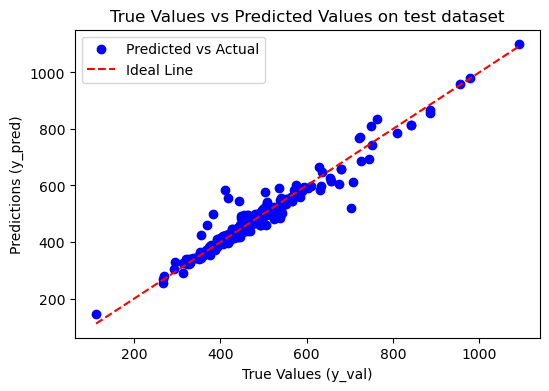

In [214]:
# Plot Predicted vs Actual Values
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
# Adding labels and title
plt.xlabel('True Values (y_val)')
plt.ylabel('Predictions (y_pred)')
plt.title('True Values vs Predicted Values on test dataset')

# Plot the diagonal line (perfect prediction line)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Line')

plt.legend()
plt.show()


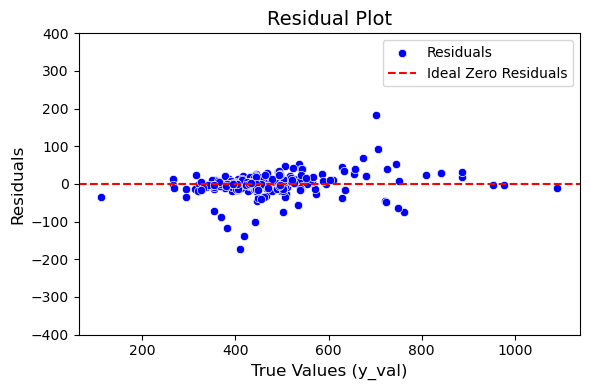

In [217]:
# Calculate residuals (errors)
residuals= y_test- y_pred
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=residuals, color='blue', label='Residuals')

# Add a horizontal line at y=0
plt.axhline(0, color='red', linestyle='--', label='Ideal Zero Residuals')

# Adding labels and title
plt.xlabel('True Values (y_val)', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Plot', fontsize=14)
plt.legend()
plt.ylim(-400, 400)

# Display the plot
plt.tight_layout()
plt.show()

## Error Analysis

In [216]:
large_residual_index=residuals[(residuals<-100) | (residuals>100)].index
df.iloc[large_residual_index]

,cmpdname,boiling_point_kelvin,mw,mf,polararea,hbonddonor,hbondacc,rotbonds,heavycnt,isosmiles,C_cnt,O_cnt,N_cnt,side_chain_cnt,double_bond_cnt,triple_bond_cnt
660,N-Methyldioctylamine,410.15,255.50,C17H37N,3.2,0,1,14,18,CCCCCCCCN(C)CCCCCCCC,17,0,1,1,0,0
611,"1,8-Octanediol",418.15,146.23,C8H18O2,40.5,2,2,7,10,C(CCCCO)CCCO,8,2,0,1,0,0
413,"1,2,3-Butanetriol",443.15,106.12,C4H10O3,60.7,3,3,2,7,CC(C(CO)O)O,4,3,0,2,0,0
578,Pentaethylene glycol,702.44,238.28,C10H22O6,77.4,2,6,13,16,C(COCCOCCOCCOCCO)O,10,6,0,1,0,0
680,N-Methyldodecylamine,382.15,199.38,C13H29N,12.0,1,1,11,14,CCCCCCCCCCCCNC,13,0,1,0,0,0


* Among the predictions with large errors, we can see the chemicals have large polar area and/or rotbonds. Those chemicals are 'outliers' of our dataset. To improve the model accuracy, we should collect more data, particularly more data with large polar area and/or rotbonds to re-train the model.

## Feature importance of XGBoost model

mw                 0.539286
O_cnt              0.183983
hbonddonor         0.072476
polararea          0.070679
side_chain_cnt     0.038456
rotbonds           0.027767
heavycnt           0.021579
C_cnt              0.019299
N_cnt              0.011084
double_bond_cnt    0.007541
triple_bond_cnt    0.004247
hbondacc           0.003604
dtype: float32
0.9326467


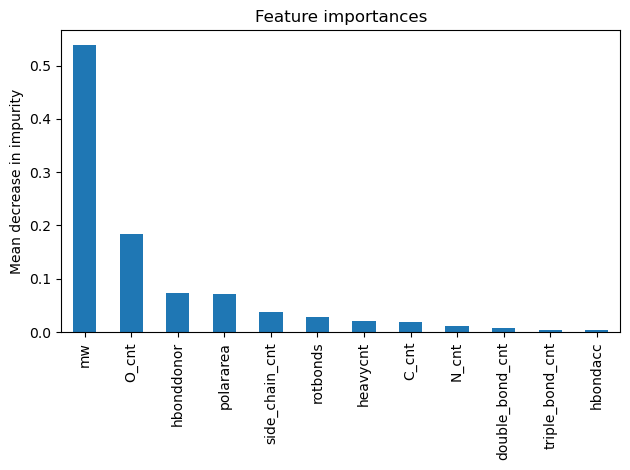

In [218]:
importances = xgb_cv.best_estimator_.feature_importances_
xgb_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
xgb_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()
print (xgb_importances)
print (np.sum(xgb_importances[:6]))

<Figure size 3000x2000 with 0 Axes>

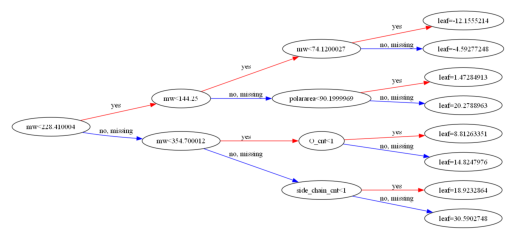

In [219]:
# Plot the tree
# Retrieve the best model (booster)
booster = xgb_cv.best_estimator_.get_booster()

# Plot the first tree from the model
plt.figure(figsize=(30, 20))
xgb.plot_tree(booster, num_trees=4, rankdir='LR')  # Change num_trees for other trees
plt.show()

 * It is shown that the major important features are: mv (molecular weight), O_cnt(count of O atom), hbonddonor(Hydrogen Bond Donor Count), polararea, side_chain_cnt (count of side-chains), rotbonds(rotable bonds number).

# Conclusions
 1. Five classic ML models, including Linear Regression, Random Forest, XGBoost, Neural Network, and Support Vector Regression are evaluated for the problem of predicting chemical compounds boiling points on a total dataset of 1588 entries. XGBoost model performed the best for this case. 
 2. Feature selection is naturally embedded with the training process of the XGBoost model. The model shows that major important features affecting boiling points for our dataset (all compouonds have no charge) are: mv (molecular weight), O_cnt(count of O atom), hbonddonor(Hydrogen Bond Donor Count), polararea, side_chain_cnt (count of side-chains), rotbonds(rotable bonds number).
 3. To further improve the model performance, collect more data (particularly more data with large polar area and/or rotbonds) to re-train the model.